[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GabbyTab/boofun/blob/main/notebooks/hw3_dnf_restrictions.ipynb)

# Problem Set 3: DNFs, Random Restrictions, and AC⁰

**CS 294-92: Analysis of Boolean Functions - Spring 2025**  
**Due: Monday, March 17, 11:59PM**
**Notebook by: Gabriel Taboada**

This notebook explores:
1. DNF formulas and their structure
2. Random restrictions and simplification
3. The Switching Lemma (Håstad)
4. Fourier concentration of DNFs
5. Mansour's Theorem
6. AC⁰ circuits and their limitations

**Reference**: O'Donnell, *Analysis of Boolean Functions*, Chapters 3-4

---

In [1]:
# Install/upgrade boofun (required for Colab)
# This ensures you have the latest version with all features
!pip install --upgrade boofun -q

import boofun as bf
print(f"BooFun version: {bf.__version__}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/quantum/__init__.py:22: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


BooFun version: 1.1.1


In [2]:
import numpy as np
import boofun as bf
from boofun.analysis import PropertyTester
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

## Background: DNF Formulas

A **DNF (Disjunctive Normal Form)** is an OR of ANDs:
$$f(x) = C_1 \lor C_2 \lor \cdots \lor C_m$$

where each **clause** $C_j$ is an AND of literals:
$$C_j = \ell_{j,1} \land \ell_{j,2} \land \cdots \land \ell_{j,w_j}$$

Key parameters:
- **Width** $w$: Maximum number of literals in a clause
- **Size** $s$: Total number of clauses

**Examples**:
- $\text{OR}_n = x_1 \lor x_2 \lor \cdots \lor x_n$ (width 1, size $n$)
- $\text{AND}_n = x_1 \land x_2 \land \cdots \land x_n$ (width $n$, size 1)
- $\text{Tribes}_{w,m}$: $m$ disjoint clauses of width $w$

In [3]:
# Create some DNF examples
# OR: width 1, size n
or_n = bf.OR(4)
print("OR₄: width-1 DNF with 4 clauses")

# AND: width n, size 1
and_n = bf.AND(4)
print("AND₄: width-4 DNF with 1 clause")

# Tribes: balanced threshold-like function
# Tribes(w, m) has w*m variables, m clauses of width w
tribes_2_3 = bf.tribes(2, 3)  # 2 clauses of width 3 → 6 variables
print(f"\nTribes(2,3): {tribes_2_3.n_vars} variables, width-3 clauses")

# Analyze their properties - using direct API
for name, f in [("OR₄", or_n), ("AND₄", and_n), ("Tribes(2,3)", tribes_2_3)]:
    print(f"\n{name}:")
    print(f"  Total influence: {f.total_influence():.4f}")
    print(f"  Fourier degree:  {f.degree()}")
    print(f"  Balanced:        {f.is_balanced()}")

OR₄: width-1 DNF with 4 clauses
AND₄: width-4 DNF with 1 clause

Tribes(2,3): 3 variables, width-3 clauses

OR₄:
  Total influence: 0.5000
  Fourier degree:  4
  Balanced:        False

AND₄:
  Total influence: 0.5000
  Fourier degree:  4
  Balanced:        False

Tribes(2,3):
  Total influence: 1.2500
  Fourier degree:  3
  Balanced:        False


## Problem 1: Random Restrictions

A **random restriction** $\rho$ fixes each variable independently:
- With probability $p$: leave the variable "alive" (unfixed)
- With probability $(1-p)/2$: fix to 0
- With probability $(1-p)/2$: fix to 1

After applying $\rho$, the function $f|_\rho$ depends only on the alive variables.

**Key insight**: Random restrictions tend to *simplify* DNFs!

In [4]:
def random_restriction(n, p):
    """
    Generate a random restriction.
    Returns (alive_vars, fixed_values) where:
    - alive_vars: list of unfixed variable indices
    - fixed_values: dict mapping fixed vars to their values
    """
    alive = []
    fixed = {}
    for i in range(n):
        r = np.random.random()
        if r < p:
            alive.append(i)
        elif r < p + (1-p)/2:
            fixed[i] = 0
        else:
            fixed[i] = 1
    return alive, fixed

def apply_restriction(f, fixed_values):
    """Apply restriction to a function, returning restricted function."""
    n = f.n_vars
    alive = [i for i in range(n) if i not in fixed_values]
    n_alive = len(alive)
    
    if n_alive == 0:
        # Fully fixed - evaluate at the single point
        x = [fixed_values[i] for i in range(n)]
        return bf.constant(bool(f.evaluate(x)), 1)
    
    # Build restricted truth table
    new_tt = []
    for j in range(2**n_alive):
        # Construct input for original function
        x = [0] * n
        for idx, alive_var in enumerate(alive):
            x[alive_var] = (j >> (n_alive - 1 - idx)) & 1
        for fixed_var, val in fixed_values.items():
            x[fixed_var] = val
        new_tt.append(f.evaluate(x))
    
    return bf.create(new_tt)

# Example: Apply random restriction to Tribes
print("Random Restriction on Tribes(2,3) with p=0.5")
print("=" * 50)

tribes = bf.tribes(2, 3)
print(f"Original: {tribes.n_vars} variables, degree {tribes.degree()}")

for trial in range(3):
    alive, fixed = random_restriction(tribes.n_vars, p=0.5)
    f_restricted = apply_restriction(tribes, fixed)
    print(f"\nTrial {trial+1}:")
    print(f"  Alive vars: {alive} ({len(alive)} alive)")
    print(f"  Fixed: {fixed}")
    print(f"  Restricted function: {f_restricted.n_vars} vars, degree {f_restricted.degree()}")

Random Restriction on Tribes(2,3) with p=0.5
Original: 3 variables, degree 3

Trial 1:
  Alive vars: [0] (1 alive)
  Fixed: {1: 1, 2: 0}
  Restricted function: 1 vars, degree 0

Trial 2:
  Alive vars: [1, 2] (2 alive)
  Fixed: {0: 0}
  Restricted function: 2 vars, degree 2

Trial 3:
  Alive vars: [0] (1 alive)
  Fixed: {1: 1, 2: 0}
  Restricted function: 1 vars, degree 0


## Problem 2: The Switching Lemma (Håstad)

**Theorem (Håstad's Switching Lemma)**: Let $f$ be a width-$w$ DNF. For a random restriction $\rho$ with parameter $p$:

$$\Pr_\rho[f|_\rho \text{ cannot be written as width-}s \text{ DNF}] \leq (5pw)^s$$

**Interpretation**: Random restrictions dramatically simplify DNFs!

- Small $p$: most variables fixed → high probability of small width
- For $p = 1/(10w)$: probability of width $> s$ is at most $(1/2)^s$

In [5]:
# Empirically verify the Switching Lemma effect
# We'll look at how degree/complexity decreases after restriction

def compute_dnf_width_approx(f):
    """
    Approximate DNF width using decision tree depth.
    DT depth ≥ DNF width (in general).
    """
    # Use Fourier degree as proxy (rough upper bound on DT depth)
    return f.degree()

# Test on width-4 Tribes
original_width = 4
tribes = bf.tribes(3, 4)  # 3 clauses of width 4 → 12 variables
print(f"Original Tribes(3,4): {tribes.n_vars} vars, width {original_width}")

# Apply many random restrictions and track simplification
p_values = [0.5, 0.25, 0.1]

for p in p_values:
    degree_after = []
    for _ in range(100):
        alive, fixed = random_restriction(tribes.n_vars, p)
        if len(alive) > 0:
            f_rest = apply_restriction(tribes, fixed)
            degree_after.append(f_rest.degree())
    
    avg_degree = np.mean(degree_after)
    max_degree = np.max(degree_after)
    print(f"\np = {p}:")
    print(f"  Expected alive vars: {p * tribes.n_vars:.1f}")
    print(f"  Average degree after: {avg_degree:.2f}")
    print(f"  Max degree observed:  {max_degree}")
    print(f"  Switching bound (5pw)^s: {(5*p*original_width):.3f}^s")

Original Tribes(3,4): 4 vars, width 4

p = 0.5:
  Expected alive vars: 2.0
  Average degree after: 1.35
  Max degree observed:  4
  Switching bound (5pw)^s: 10.000^s

p = 0.25:
  Expected alive vars: 1.0
  Average degree after: 0.77
  Max degree observed:  4
  Switching bound (5pw)^s: 5.000^s

p = 0.1:
  Expected alive vars: 0.4
  Average degree after: 0.29
  Max degree observed:  1
  Switching bound (5pw)^s: 2.000^s


## Problem 3: Fourier Concentration of DNFs

**Theorem (Mansour's Theorem)**: A width-$w$ DNF with $s$ clauses has its Fourier spectrum 
$\varepsilon$-concentrated on at most $s \cdot (w/\varepsilon)^{O(w \log w)}$ coefficients.

More specifically, the Fourier spectrum is concentrated on low degrees:

**Lemma**: For width-$w$ DNF: $\mathbf{W}^{>k}[f] \leq s \cdot (2^w)^{-k/(2w)}$

where $\mathbf{W}^{>k}[f] = \sum_{|S|>k} \hat{f}(S)^2$ is the weight on degree $>k$.

In [6]:
# Verify Fourier concentration for various DNFs
def spectral_concentration_by_degree(f):
    """Return dict mapping degree k to weight W^{=k}."""
    n = f.n_vars
    # Direct API: f.fourier()
    coeffs = f.fourier()
    
    weight_by_degree = {}
    for i, c in enumerate(coeffs):
        deg = bin(i).count('1')  # Hamming weight = degree
        weight_by_degree[deg] = weight_by_degree.get(deg, 0) + c**2
    
    return weight_by_degree

def cumulative_concentration(weight_dict, max_k):
    """Weight on degree ≤ k."""
    return sum(weight_dict.get(d, 0) for d in range(max_k + 1))

# Test DNFs
dnfs = {
    "OR₅ (w=1)": (bf.OR(5), 1, 5),
    "AND₅ (w=5)": (bf.AND(5), 5, 1),
    "Tribes(2,3) (w=3)": (bf.tribes(2, 3), 3, 2),
    "Tribes(3,3) (w=3)": (bf.tribes(3, 3), 3, 3),
}

print("Fourier Concentration of DNFs")
print("=" * 70)

for name, (f, width, size) in dnfs.items():
    weights = spectral_concentration_by_degree(f)
    max_deg = max(weights.keys())
    
    print(f"\n{name}:")
    print(f"  Variables: {f.n_vars}, Width: {width}, Size: {size}")
    
    # Show cumulative concentration
    print("  Cumulative weight:")
    for k in range(max_deg + 1):
        cum = cumulative_concentration(weights, k)
        pct = cum * 100
        bar = "█" * int(pct // 5)
        print(f"    W^{{≤{k}}}: {cum:.4f} ({pct:.1f}%) {bar}")

Fourier Concentration of DNFs

OR₅ (w=1):
  Variables: 5, Width: 1, Size: 5
  Cumulative weight:
    W^{≤0}: 0.8789 (87.9%) █████████████████
    W^{≤1}: 0.8984 (89.8%) █████████████████
    W^{≤2}: 0.9375 (93.8%) ██████████████████
    W^{≤3}: 0.9766 (97.7%) ███████████████████
    W^{≤4}: 0.9961 (99.6%) ███████████████████
    W^{≤5}: 1.0000 (100.0%) ████████████████████

AND₅ (w=5):
  Variables: 5, Width: 5, Size: 1
  Cumulative weight:
    W^{≤0}: 0.8789 (87.9%) █████████████████
    W^{≤1}: 0.8984 (89.8%) █████████████████
    W^{≤2}: 0.9375 (93.8%) ██████████████████
    W^{≤3}: 0.9766 (97.7%) ███████████████████
    W^{≤4}: 0.9961 (99.6%) ███████████████████
    W^{≤5}: 1.0000 (100.0%) ████████████████████

Tribes(2,3) (w=3):
  Variables: 3, Width: 3, Size: 2
  Cumulative weight:
    W^{≤0}: 0.0625 (6.2%) █
    W^{≤1}: 0.7500 (75.0%) ███████████████
    W^{≤2}: 0.9375 (93.8%) ██████████████████
    W^{≤3}: 1.0000 (100.0%) ████████████████████

Tribes(3,3) (w=3):
  Variables: 3, 

## Problem 4: AC⁰ Circuits and Parity

**AC⁰**: The class of constant-depth, polynomial-size circuits with unbounded fan-in AND/OR gates.

**Major Result (Håstad 1986)**: $\text{Parity}_n \notin \text{AC}^0$

More precisely: Any depth-$d$ circuit computing $\text{Parity}_n$ requires size $\exp(\Omega(n^{1/(d-1)}))$.

**Proof technique**: Repeated random restrictions until the function becomes constant, while Parity remains "hard".

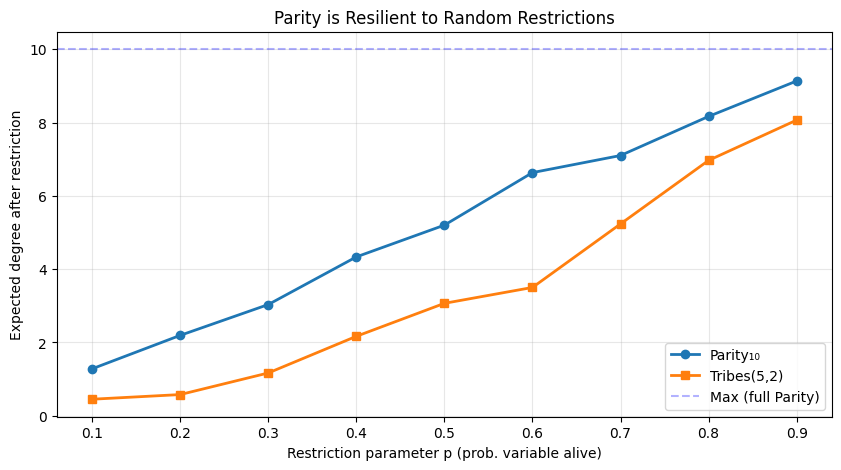


Key insight: Parity maintains high degree even under restrictions!
   This is why Parity cannot be computed by AC⁰ circuits.


In [ ]:
# Compare how Parity vs DNFs behave under restrictions
# Key insight: Parity NEVER simplifies - restricted Parity is still Parity!

def parity_resilience(n, p, trials=50):
    """Show that Parity restricted is still non-trivial."""
    parity = bf.parity(n)
    
    degrees = []
    for _ in range(trials):
        alive, fixed = random_restriction(n, p)
        if len(alive) > 0:
            f_rest = apply_restriction(parity, fixed)
            degrees.append(f_rest.degree())
    
    return np.mean(degrees) if degrees else 0

# Compare Parity vs Tribes under restrictions
n = 10
p_values = np.linspace(0.1, 0.9, 9)

parity_degrees = []
tribes_degrees = []

for p in p_values:
    # Parity
    parity = bf.parity(n)
    par_deg = []
    for _ in range(30):
        alive, fixed = random_restriction(n, p)
        if len(alive) > 0:
            f_rest = apply_restriction(parity, fixed)
            par_deg.append(f_rest.degree())
    parity_degrees.append(np.mean(par_deg) if par_deg else 0)
    
    # Tribes (width 2, 5 clauses = 10 variables)
    tribes = bf.tribes(2, 10)
    tri_deg = []
    for _ in range(30):
        alive, fixed = random_restriction(tribes.n_vars, p)
        if len(alive) > 0:
            f_rest = apply_restriction(tribes, fixed)
            tri_deg.append(f_rest.degree())
    tribes_degrees.append(np.mean(tri_deg) if tri_deg else 0)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(p_values, parity_degrees, 'o-', label='Parity₁₀', linewidth=2)
ax.plot(p_values, tribes_degrees, 's-', label='Tribes(5,2)', linewidth=2)
ax.axhline(y=n, color='blue', linestyle='--', alpha=0.3, label='Max (full Parity)')

ax.set_xlabel('Restriction parameter p (prob. variable alive)')
ax.set_ylabel('Expected degree after restriction')
ax.set_title('Parity is Resilient to Random Restrictions')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

print("\nKey insight: Parity maintains high degree even under restrictions!")
print("   This is why Parity cannot be computed by AC⁰ circuits.")

## Problem 5: Pseudorandomness and Fooling AC⁰

A distribution $\mathcal{D}$ on $\{0,1\}^n$ **$\varepsilon$-fools** a function class $\mathcal{C}$ if:

$$\forall f \in \mathcal{C}: |\mathbf{E}_{x \sim \mathcal{D}}[f(x)] - \mathbf{E}_{x \sim U_n}[f(x)]| \leq \varepsilon$$

**Result**: AC⁰ can be fooled by $O(\log n)$-wise independent distributions!

This connects to the Fourier concentration of AC⁰:
- If $f$ has most weight on low-degree, it can't distinguish distributions that match low-order moments.

## Summary

### Key Takeaways from HW3:

1. **DNF Structure**:
   - Width $w$: max literals per clause
   - Size $s$: number of clauses
   - Tribes: canonical balanced DNF

2. **Random Restrictions**:
   - Fix each variable with probability $1-p$
   - Simplify DNFs dramatically

3. **Switching Lemma** (Håstad):
   - $\Pr[f|_\rho \text{ has width } > s] \leq (5pw)^s$
   - Key tool for proving circuit lower bounds

4. **Fourier Concentration**:
   - DNFs have spectra concentrated on low degrees
   - Leads to PAC learning (Mansour's Theorem)

5. **AC⁰ vs Parity**:
   - Parity is resilient to random restrictions
   - $\Rightarrow$ Parity $\notin$ AC⁰ (exponential lower bound)

6. **Pseudorandomness**:
   - Low-degree functions can be fooled by $k$-wise independent distributions

### Using boofun (Direct API):

```python
import boofun as bf

# Create DNFs
tribes = bf.tribes(w, m)  # m clauses of width w
or_n = bf.OR(n)           # width-1 DNF

# Analyze spectrum - direct methods!
fourier = tribes.fourier()       # No SpectralAnalyzer needed
degree = tribes.degree()
influences = tribes.influences()

# Apply restrictions via f.fix(var, val)
restricted = f.fix(0, 1)  # Fix x₀ = 1
```